# File and libraries

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


filepath=r'data/df_gira_pre_proc.csv'

file_tag = "Gira Bike"


# DSLabs functions

In [50]:
%run "scripts/dslabs_functions.py"


# Data functions

In [51]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [52]:
# test_data=True
test_data=False

df=pd.read_csv(filepath, sep=';', decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10814 entries, 01/01/2022 12:00 to 31/03/2023 22:00
Data columns (total 12 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   temperature_2m                                               10814 non-null  float64
 1   rain_mm                                                      10814 non-null  float64
 2   wmo_weather_code                                             10814 non-null  int64  
 3   wind_speed_10m                                               10814 non-null  float64
 4   is_holiday_lisbon                                            10814 non-null  float64
 5   target_station_status                                        9684 non-null   float64
 6   target_station_load_rate                                     9684 non-null   float64
 7   station_load_rate_ Rua do Arco Cego / Av. Magalhães Lim

# Missing values Analysis

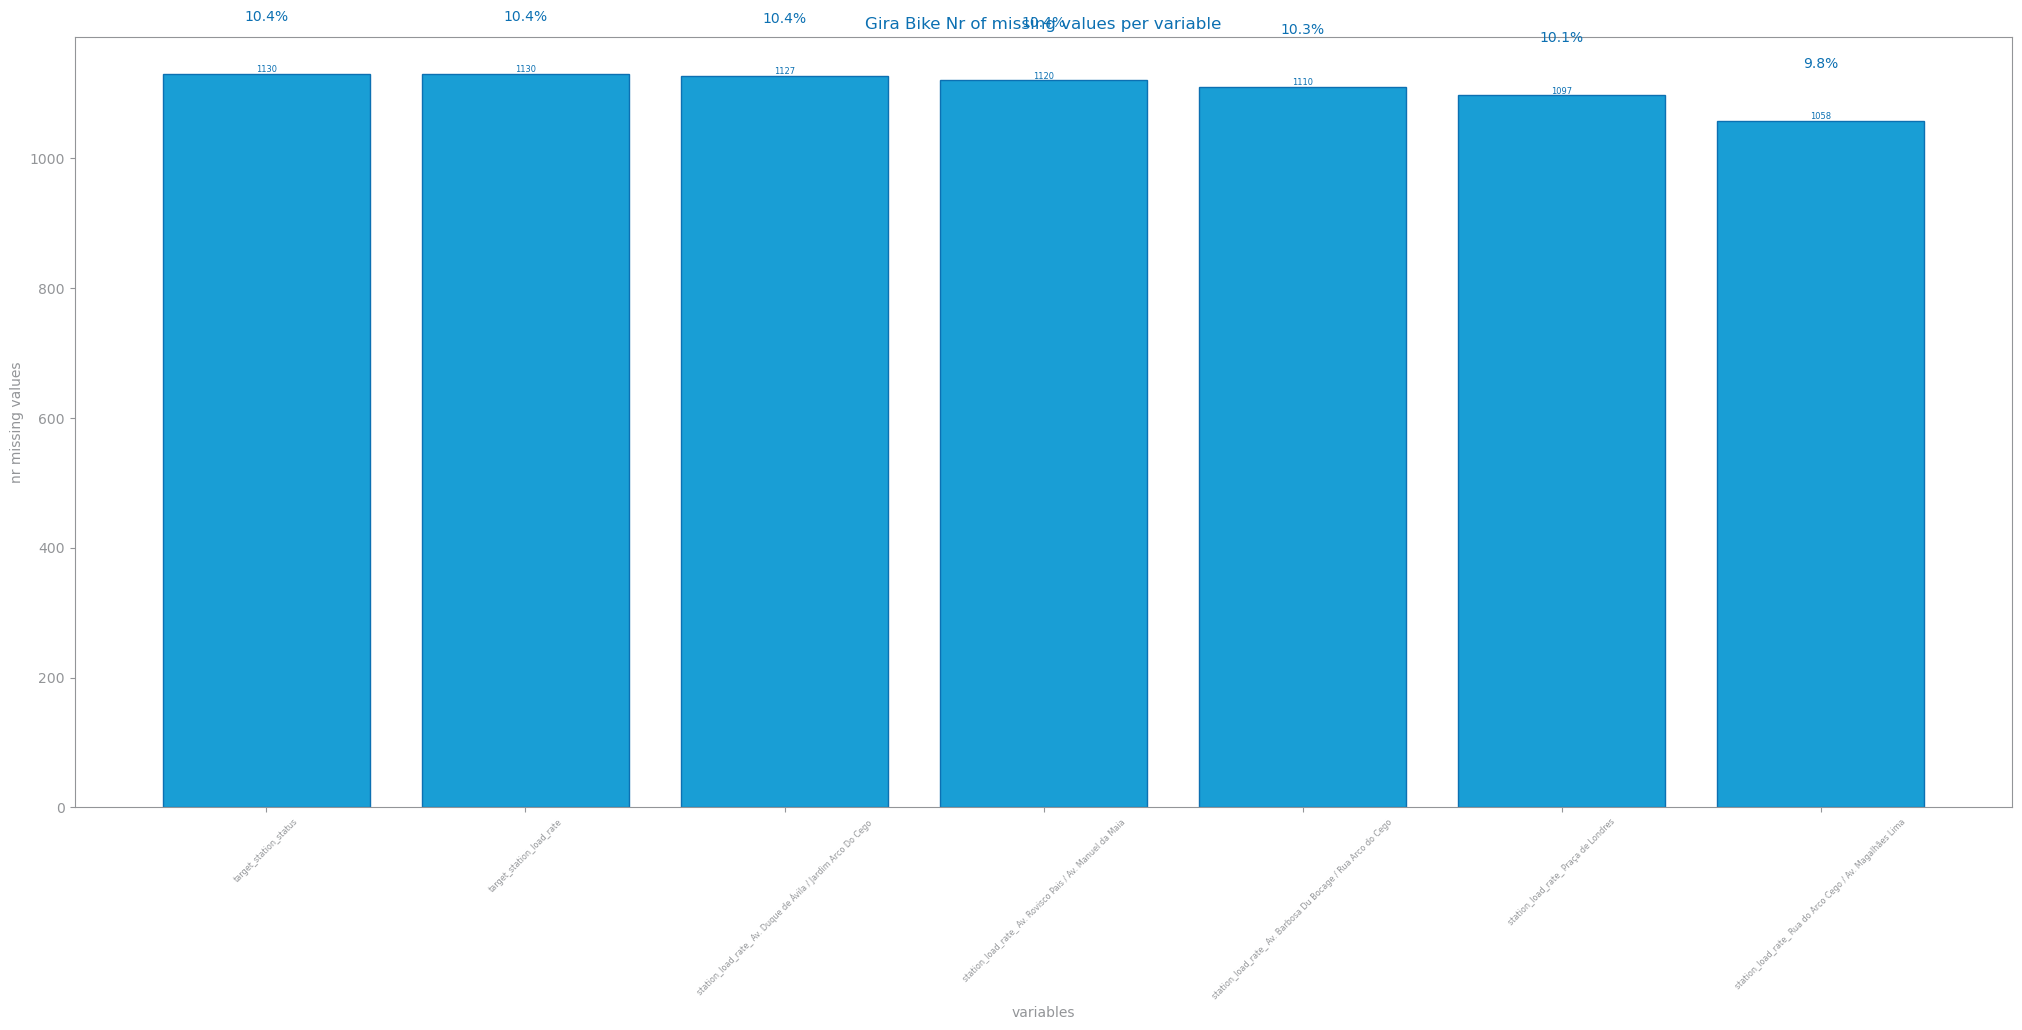

In [53]:

from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

mv: dict[str, int] = {}
total_rows = len(df)

for var in df.columns:
    nr: int = df[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

figure(figsize=(25, 10)) #(largura,altura) 

plot_bar_chart(
    variables,
    missing_values,
    title=f"{file_tag} Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

savefig(f"images/{file_tag}_mv.png")
show()

In [54]:
df_mv = df[df.isna().any(axis=1)]

display(df_mv.head())
display(df_mv.shape)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,16.9,0.0,3,5.4,1.0,1.0,36.0,28.6,50.0,60.0,8.7,NaN
01/01/2022 13:00,17.9,0.0,3,5.5,1.0,1.0,32.0,28.6,46.2,NaN,15.9,16.7
01/01/2022 14:00,18.4,0.0,3,5.6,1.0,NaN,NaN,NaN,NaN,70.0,NaN,20.0
01/01/2022 18:00,13.9,0.0,3,7.4,1.0,1.0,4.0,28.6,21.1,30.0,NaN,10.0
01/01/2022 21:00,13.8,0.0,3,8.9,1.0,1.0,4.0,21.4,38.5,30.0,NaN,NaN


(4517, 12)

## Missing values Treatment
- We can apply several missing values treatment techniques
    - KNN
    - ARIMA
    - Interpolate: The linear interpolation (interpolate) method was used to fill in missing values (NaN) in the dataset. This method estimates missing values by assuming a linear variation between the previous and next known data points within the same column. In other words, for each missing value, the algorithm calculates an intermediate value by drawing a straight line between the nearest available data points.
    - Fill na's with average of previous and next point in time
- In this step, we will not evaluate the results of transformation and we will aply the treamtment tecnique:
    - Fill na's with average of previous and next point in time

### MV 1 Treat - Interpolate

In [10]:
df.head()

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,16.9,0.0,3,5.4,1.0,1.0,36.0,28.6,50.0,60.0,8.7,NaN
01/01/2022 13:00,17.9,0.0,3,5.5,1.0,1.0,32.0,28.6,46.2,NaN,15.9,16.7
01/01/2022 14:00,18.4,0.0,3,5.6,1.0,NaN,NaN,NaN,NaN,70.0,NaN,20.0
01/01/2022 15:00,18.6,0.0,3,5.8,1.0,1.0,20.0,14.3,37.2,67.5,13.0,10.0
01/01/2022 16:00,17.9,0.0,2,5.9,1.0,1.0,18.0,32.8,5.8,48.6,13.0,10.0


#### Interpolate

In [55]:
# Preencher valores NaN usando interpolação linear
df_filled_interpolate = df.interpolate(method='linear', axis=0).round(1)#axis= 0 - a cada linha

# Verificar o resultado
display(df_filled_interpolate.head(10))

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,16.9,0.0,3,5.4,1.0,1.0,36.0,28.6,50.0,60.0,8.7,NaN
01/01/2022 13:00,17.9,0.0,3,5.5,1.0,1.0,32.0,28.6,46.2,65.0,15.9,16.7
01/01/2022 14:00,18.4,0.0,3,5.6,1.0,1.0,26.0,21.5,41.7,70.0,14.4,20.0
01/01/2022 15:00,18.6,0.0,3,5.8,1.0,1.0,20.0,14.3,37.2,67.5,13.0,10.0
01/01/2022 16:00,17.9,0.0,2,5.9,1.0,1.0,18.0,32.8,5.8,48.6,13.0,10.0
01/01/2022 17:00,15.5,0.0,3,6.5,1.0,1.0,4.0,26.2,11.5,35.0,2.2,5.0
01/01/2022 18:00,13.9,0.0,3,7.4,1.0,1.0,4.0,28.6,21.1,30.0,1.1,10.0
01/01/2022 19:00,13.9,0.0,3,7.9,1.0,1.0,4.0,17.8,34.6,0.0,0.0,10.0
01/01/2022 20:00,13.9,0.0,3,8.7,1.0,1.0,4.0,21.4,34.6,20.0,15.2,10.0


In [45]:
df.head(10)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,16.9,0.0,3,5.4,1.0,1.0,36.0,28.60,50.0,60.0,8.700,16.7
01/01/2022 13:00,17.9,0.0,3,5.5,1.0,1.0,32.0,28.60,46.2,65.0,15.900,16.7
01/01/2022 14:00,18.4,0.0,3,5.6,1.0,1.0,26.0,21.45,41.7,70.0,14.450,20.0
01/01/2022 15:00,18.6,0.0,3,5.8,1.0,1.0,20.0,14.30,37.2,67.5,13.000,10.0
01/01/2022 16:00,17.9,0.0,2,5.9,1.0,1.0,18.0,32.80,5.8,48.6,13.000,10.0
01/01/2022 17:00,15.5,0.0,3,6.5,1.0,1.0,4.0,26.20,11.5,35.0,2.200,5.0
01/01/2022 18:00,13.9,0.0,3,7.4,1.0,1.0,4.0,28.60,21.1,30.0,1.100,10.0
01/01/2022 19:00,13.9,0.0,3,7.9,1.0,1.0,4.0,17.80,34.6,0.0,0.000,10.0
01/01/2022 20:00,13.9,0.0,3,8.7,1.0,1.0,4.0,21.40,34.6,20.0,15.200,10.0


In [56]:
df_mv_treat_1 = df_filled_interpolate[df_filled_interpolate.isna().any(axis=1)]

display(df_mv_treat_1.head())
display(df_mv_treat_1.shape)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,16.9,0.0,3,5.4,1.0,1.0,36.0,28.6,50.0,60.0,8.7,NaN


(1, 12)

##### Fazer f-fill e b-fill para preencher com o valor seguinte nos casos em que não temos pontos anteriores aos nas

In [57]:
df_filled_interpolate = df_filled_interpolate.fillna(method='ffill').fillna(method='bfill')
df

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,16.9,0.0,3,5.4,1.0,1.0,36.0,28.6,50.0,60.0,8.7,NaN
01/01/2022 13:00,17.9,0.0,3,5.5,1.0,1.0,32.0,28.6,46.2,NaN,15.9,16.7
01/01/2022 14:00,18.4,0.0,3,5.6,1.0,NaN,NaN,NaN,NaN,70.0,NaN,20.0
01/01/2022 15:00,18.6,0.0,3,5.8,1.0,1.0,20.0,14.3,37.2,67.5,13.0,10.0
01/01/2022 16:00,17.9,0.0,2,5.9,1.0,1.0,18.0,32.8,5.8,48.6,13.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31/03/2023 18:00,17.1,0.0,3,11.7,0.0,1.0,16.0,14.3,58.6,53.3,32.6,20.0
31/03/2023 19:00,15.7,0.0,3,7.9,0.0,1.0,20.0,36.7,47.5,28.6,15.2,20.0
31/03/2023 20:00,14.7,0.0,3,6.9,0.0,1.0,20.5,59.5,32.0,11.4,21.7,25.0


In [58]:
df_mv_treat_1 = df_filled_interpolate[df_filled_interpolate.isna().any(axis=1)]

display(df_mv_treat_1.head())
display(df_mv_treat_1.shape)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,


(0, 12)

In [59]:
display(df_filled_interpolate.head())
display(df_filled_interpolate.shape)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,16.9,0.0,3,5.4,1.0,1.0,36.0,28.6,50.0,60.0,8.7,16.7
01/01/2022 13:00,17.9,0.0,3,5.5,1.0,1.0,32.0,28.6,46.2,65.0,15.9,16.7
01/01/2022 14:00,18.4,0.0,3,5.6,1.0,1.0,26.0,21.5,41.7,70.0,14.4,20.0
01/01/2022 15:00,18.6,0.0,3,5.8,1.0,1.0,20.0,14.3,37.2,67.5,13.0,10.0
01/01/2022 16:00,17.9,0.0,2,5.9,1.0,1.0,18.0,32.8,5.8,48.6,13.0,10.0


(10814, 12)

# save to csv

In [63]:
df = df_filled_interpolate.copy() 
df.reset_index(inplace=True)
    
df.to_csv(f"data/df_gira_mv_input.csv", index=False)
    